## Classify Emails beyond spams - using Hierarchical Clustering 

### This notebook shows the implementation of hierarchical clustering with WSD i.e. Word Sense Disambiguation. The synonyms have been included here. Level 2

### Final Project - Riti Chakraborty

In [1]:
#Riti Chakraborty
#importing the required libraries
import pandas as pd
import numpy as np
from numpy import nan

#For random seed
import random

#To handle warnings
import warnings
warnings.filterwarnings('ignore')

#library used for implementing hierarchical clustering 
import scipy

#For flattening lists
from itertools import chain

#For plotting data
import matplotlib.pyplot as plt


#library for tf-idf vector and other similarities measure
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#For implementing Natural Language Processing approaches.
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

#For using Regular expression
import re

#For Handling Strings
import string


#For implementing word sense disambiguation
from nltk.corpus import wordnet as wn
from wordsegment import load, segment

#Important to call load()
load()

#For LDA Implementation # Importing Gensim
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import gensim
from gensim import corpora


#Libraries for hierarchical clustering
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.cluster.hierarchy as sch
from collections import defaultdict
from matplotlib.colors import rgb2hex
from matplotlib.colors import colorConverter


#For evaluation Topic models formed
from gensim.models import CoherenceModel

#For visualising LDA Output
import pyLDAvis
import pyLDAvis.gensim 



### Reading the file genrated from Project_Hierarchical_Clustering1.ipynb. It contains the semi preprocessed version of the data.

At each level the data set is varying with the addition of synonyms and hypernyms. Therefore, the advanced pre-processing steps have been repeated at each level.

In [2]:
#This file read here, has been generated by the data_preprocess.ipynb.
data_subset=pd.read_csv("../exported_tables/data_subset.csv")

#converting the data in the dataframe into str type
data_subset = data_subset.astype(str) 

#retaining proper index
data_subset=data_subset.reset_index(drop=True)
num_of_rows=len(data_subset.index)

# Converting each row to list of lists
list1=data_subset.values.tolist()
list2=[]

# Converting each sublist into string and storing it in list2
for i in range(0, len(list1)):
    list2.append(' '.join(map(str, list1[i])))

#converting each row into vectors #Printing the count of each term in the emails #Emails on Rows and Terms on columns
vectorizer1 = CountVectorizer()
row_vectors=vectorizer1.fit_transform(list2).todense()


### Defining function for stop word removal

In [3]:
def stopword_remove(l2):
    fil_list2=[]
    for sent in l2:
        stop_words=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "spam","yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
        word_tokens = word_tokenize(sent.lower())
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        filtered_sentence = []

        for w in word_tokens:
            if w not in stop_words:
                filtered_sentence.append(w)

        fil_list2.append(' '.join(filtered_sentence))
    return fil_list2
fil_list2=stopword_remove(list2)

### Defining function for punctuation removal

In [4]:
#Function to remove punctuation
def no_punctuation(my_str):
    punctuations = '''!()-[]{};:'"\\,<>./?@#$%^&*_~'''
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # returning the unpunctuated string
    return no_punct

### The function defined below deals with extraction and addition of synonyms from the wordnet API to the datset and segementation of words.

In [5]:
#Function for word segmentation and word sense disambiguation
def seg_syn(l1):
    wordlist2=[]
    wordlist2.append(no_punctuation(l1).split())
    seg=[]
    for w in wordlist2:
        no_integers = [x for x in w if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]
        pure_string=[x for x in no_integers if not any(c.isdigit() for c in x)]
        for s in pure_string:
            seg.append(segment(s))
    flat_seg_list = [item for sublist in seg for item in sublist]
    d = {'Term':[], 'Synonyms':[], 'Hypernyms':[]}
    d1={}
    syn0=[]
    hyp0=[]
    for f in flat_seg_list:
        d['Term'].append(f)        
        for syn in wn.synsets(f):
            synsets=syn
            for l in syn.lemmas():
                syn0.append(l.name())
                d1[f]=l.name()
                d['Synonyms'].append(l.name())

#             for synset in synsets.hyponyms():
#                 for lemma in synset.lemmas():
#                     d['Hypernyms'].append(lemma.name())
#                     hyp0.append(lemma.name())
    return syn0,flat_seg_list


In [6]:
#Storing the values returned from the function defined above.
list2_syn=[]
for l in fil_list2:

    #Storing the synonyms along with their corresponding terms returned from the previous function
    syno,termz=seg_syn(str(l))
    list2_syn.append(syno+termz)     


#Converting back to strings
flat_list2_syn=[]
for ls in list2_syn:
    flat_list2_syn.append(' '.join(list(set(ls))))

#Storing the final list in the form of a data frame
df_flatlist=pd.DataFrame(flat_list2_syn)
df_flatlist["Index"]=df_flatlist.index

# Hierarchical Clustering

In [7]:
#Unsupervised Kmeans clustering
vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)
X = vect.fit_transform(flat_list2_syn)

#Converting to Matrix form
X_matrix=X.todense()

#Terms in overall dataset
terms = vect.get_feature_names()


# Version 1
# H. Clustering using Ward Linkage and Euclidean distance metric

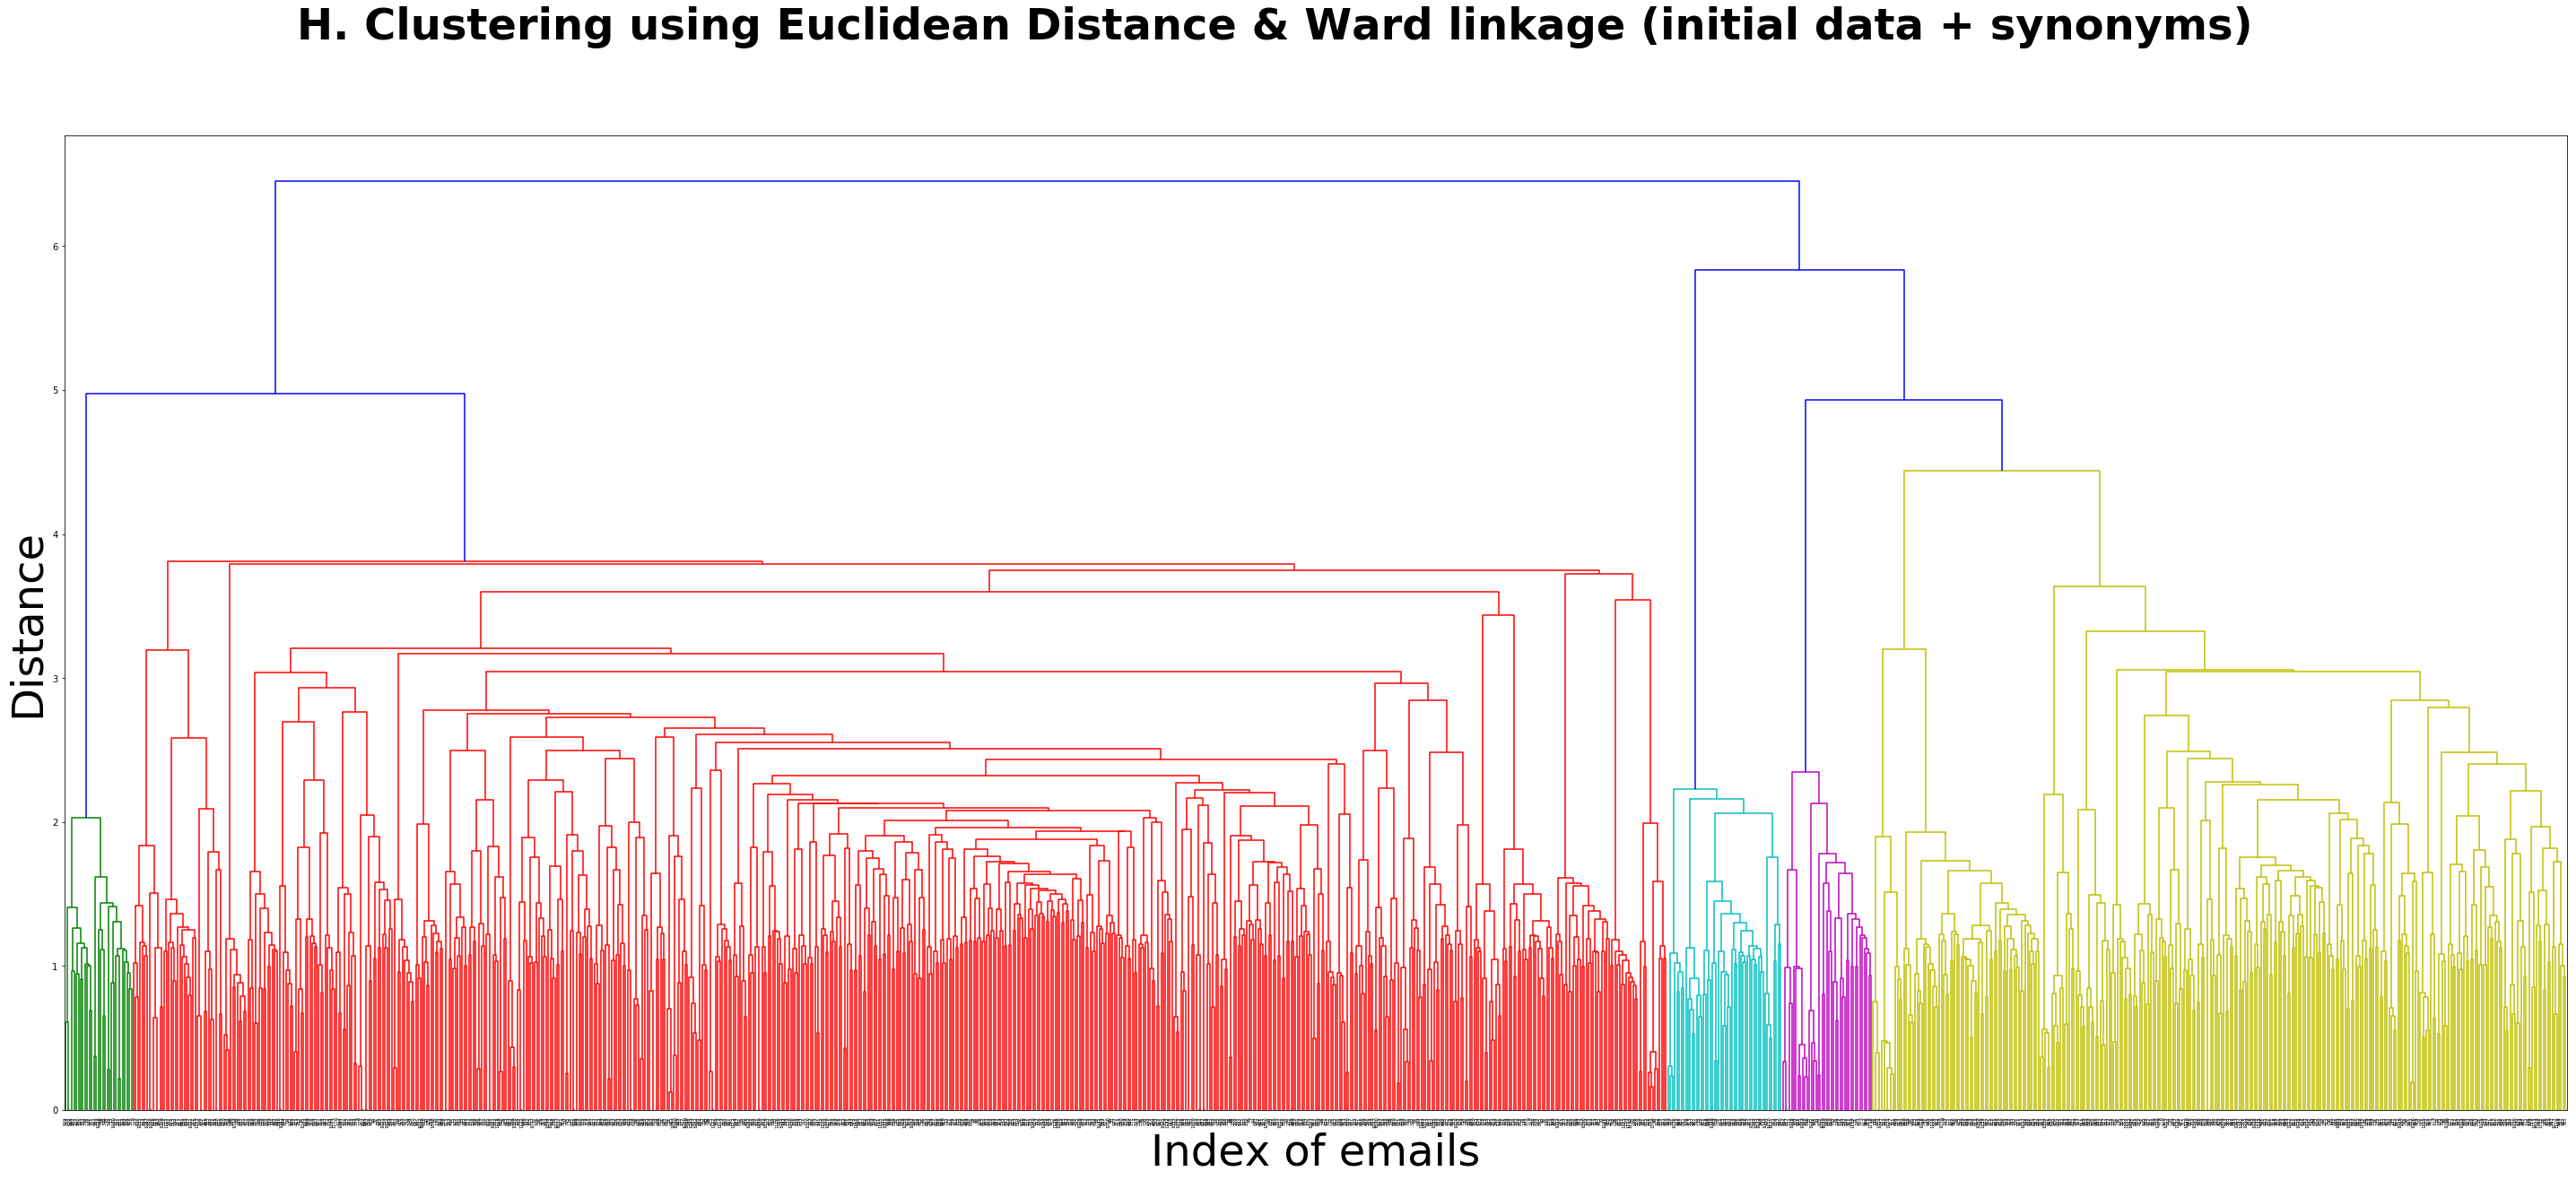

In [8]:
# Setting fugure size
plt.subplots(figsize=(50, 20))

# dend1=dendrogram(data_link)
plt.xlabel('Index of emails', fontsize=48)
plt.ylabel('Distance', fontsize=48)
plt.suptitle('H. Clustering using Euclidean Distance & Ward linkage (initial data + synonyms)', fontweight='bold', fontsize=48);
dend1 = sch.dendrogram(sch.linkage(X.todense(), method='ward',  metric='euclidean'))
plt.savefig("../results_dendrograms_kmeans_visualisation/HC1L2.png")

In [9]:

#Reference : http://www.nxn.se/valent/extract-cluster-elements-by-color-in-python
# Particularly for this cell

class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">''<td style="background-color: {0}; ''border: 0;">''<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'

        html += '</table>'

        return html

def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    #Extracting Color list and the index coordinates
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l

    return cluster_classes


#Getting the clusters w.r.t. different colors
get_cluster_classes(dend1)

{'c': ['384',
  '741',
  '999',
  '223',
  '965',
  '481',
  '881',
  '1036',
  '197',
  '961',
  '315',
  '274',
  '18',
  '169',
  '291',
  '176',
  '451',
  '618',
  '838',
  '949',
  '484',
  '578',
  '1098',
  '425',
  '664',
  '383',
  '697',
  '814',
  '77',
  '564',
  '726',
  '519',
  '389',
  '968',
  '806',
  '581',
  '325',
  '901',
  '589',
  '1043',
  '1013',
  '568',
  '750',
  '1033',
  '1010',
  '1131',
  '490',
  '1044',
  '752',
  '804',
  '207',
  '990'],
 'g': ['258',
  '629',
  '529',
  '445',
  '462',
  '127',
  '940',
  '195',
  '333',
  '586',
  '711',
  '76',
  '339',
  '427',
  '984',
  '89',
  '399',
  '976',
  '1028',
  '78',
  '599',
  '13',
  '1080',
  '251',
  '652',
  '505',
  '177',
  '368',
  '166',
  '499',
  '503'],
 'm': ['524',
  '627',
  '507',
  '133',
  '1058',
  '555',
  '905',
  '168',
  '896',
  '1063',
  '329',
  '154',
  '181',
  '745',
  '1032',
  '33',
  '49',
  '602',
  '1055',
  '1089',
  '639',
  '699',
  '939',
  '75',
  '229',
  '755',
  '139',
  '897',
  '232',
  '548',
  '911',
  '855',
  '1129',
  '71',
  '243',
  '819',
  '1108',
  '780',
  '612',
  '2',
  '567'],
 'r': ['255',
  '620',
  '5',
  '494',
  '1087',
  '173',
  '1035',
  '930',
  '1048',
  '809',
  '963',
  '111',
  '406',
  '1008',
  '352',
  '1113',
  '515',
  '534',
  '875',
  '761',
  '827',
  '1022',
  '659',
  '854',
  '651',
  '817',
  '372',
  '909',
  '321',
  '106',
  '432',
  '1123',
  '311',
  '980',
  '480',
  '872',
  '323',
  '385',
  '868',
  '621',
  '649',
  '784',
  '858',
  '600',
  '989',
  '1003',
  '398',
  '861',
  '391',
  '457',
  '68',
  '59',
  '576',
  '888',
  '204',
  '786',
  '917',
  '29',
  '869',
  '148',
  '510',
  '644',
  '799',
  '443',
  '885',
  '790',
  '696',
  '1081',
  '142',
  '933',
  '64',
  '975',
  '794',
  '302',
  '413',
  '45',
  '1041',
  '263',
  '633',
  '859',
  '454',
  '837',
  '216',
  '289',
  '314',
  '358',
  '957',
  '1084',
  '1107',
  '138',
  '373',
  '987',
  '522',
  '1097',
  '6',
  '287',
  '324',
  '335',
  '781',
  '159',
  '364',
  '818',
  '375',
  '807',
  '8',
  '895',
  '907',
  '738',
  '920',
  '44',
  '57',
  '756',
  '962',
  '334',
  '1002',
  '1021',
  '265',
  '844',
  '167',
  '623',
  '69',
  '416',
  '459',
  '680',
  '34',
  '273',
  '307',
  '260',
  '491',
  '1042',
  '637',
  '40',
  '350',
  '606',
  '1065',
  '70',
  '150',
  '593',
  '886',
  '1046',
  '288',
  '350',
  '336',
  '615',
  '153',
  '437',
  '15',
  '107',
  '295',
  '430',
  '387',
  '948',
  '63',
  '117',
  '174',
  '128',
  '772',
  '346',
  '986',
  '327',
  '770',
  '632',
  '840',
  '242',
  '952',
  '1118',
  '1051',
  '157',
  '898',
  '28',
  '463',
  '438',
  '1068',
  '663',
  '683',
  '436',
  '1122',
  '724',
  '630',
  '700',
  '725',
  '1007',
  '182',
  '37',
  '929',
  '313',
  '842',
  '758',
  '91',
  '718',
  '736',
  '1011',
  '1094',
  '1077',
  '1092',
  '501',
  '514',
  '97',
  '743',
  '831',
  '846',
  '23',
  '719',
  '970',
  '249',
  '778',
  '779',
  '160',
  '707',
  '318',
  '253',
  '723',
  '667',
  '164',
  '489',
  '468',
  '580',
  '926',
  '305',
  '862',
  '256',
  '783',
  '530',
  '733',
  '674',
  '634',
  '759',
  '388',
  '66',
  '635',
  '628',
  '486',
  '958',
  '558',
  '953',
  '583',
  '879',
  '974',
  '19',
  '404',
  '41',
  '947',
  '808',
  '21',
  '982',
  '682',
  '1093',
  '1099',
  '285',
  '382',
  '1060',
  '1069',
  '472',
  '653',
  '1061',
  '1083',
  '246',
  '546',
  '884',
  '94',
  '782',
  '523',
  '473',
  '1127',
  '99',
  '709',
  '1114',
  '735',
  '561',
  '841',
  '992',
  '450',
  '119',
  '114',
  '662',
  '1112',
  '340',
  '466',
  '26',
  '631',
  '162',
  '554',
  '1082',
  '591',
  '1070',
  '206',
  '832',
  '1079',
  '500',
  '247',
  '552',
  '386',
  '1034',
  '1116',
  '83',
  '184',
  '732',
  '894',
  '129',
  '1049',
  '280',
  '538',
  '171',
  '17',
  '777',
  '677',
  '834',
  '767',
  '820',
  '1066',
  '137',
  '641',
  '225',
  '194',
  '1016',
  '1128',


In [10]:
cluster_index = defaultdict(list)
for c, pi in zip(dend1['color_list'], dend1['icoord']):
    for leg in pi[1:3]:
        i = (leg - 5.0) / 10.0
        if abs(i - int(i)) < 1e-5:
            cluster_index[c].append(int(i))

#Creating list of dataframes
list_of_values=[]
for k, v in cluster_index.items():
    list_of_values.append(v)

l_df=[]
for l in list_of_values:
    df_ = pd.concat([pd.DataFrame(l), df_flatlist], axis=1, join='inner')
    l_df.append(df_)


In [11]:
# len(l_df)
print("Output by Hierarchical clustering \n")
list_l_df=[]

#For counting the number of emails in each class
i=0
for l_d in l_df:
    print("Total Emails in this cluster", i,"=",len(l_d.values.tolist()))
    i+=1
    list_l_df.append(l_d.iloc[:,1:].values.tolist())

Output by Hierarchical clustering 

Total Emails in this cluster 0 = 31
Total Emails in this cluster 1 = 711
Total Emails in this cluster 2 = 52
Total Emails in this cluster 3 = 41
Total Emails in this cluster 4 = 318


In [12]:
def seg_clust(l1):
    wordlist2=[]
    wordlist2.append(no_punctuation(l1).split())
    seg=[]
    for w in wordlist2:
        no_integers = [x for x in w if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]
        pure_string=[x for x in no_integers if not any(c.isdigit() for c in x)]
        for s in pure_string:
            seg.append(segment(s))
    return(seg)

len_listofdf=len(list_l_df)

# LDA on the extracted dataframes

In [13]:
def data_prep_for_lda(i):
    d_comp=[]
    for d in list_l_df[i]:
        d_comp.append(''.join(str(d)))
    seg_cl=seg_clust(d_comp)
    lists_cl=[]
    for s_cl in seg_cl:
        lists_cl.append(' '.join(s_cl))
    return lists_cl

In [14]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()


def clean(doc):
    
    #Removing words with length <3
    clean_str=[(re.sub(r'\b\w{1,3}\b', '', doc))]
    
    #Removing Empty elements
    clean_str=list(filter(None, clean_str))
    
    #Removing Stopwords
    stop_free = " ".join([i for i in str(clean_str).lower().split() if i not in stop])
    
    #Removing Punctuation
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    
    #for stemming 
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    
    result = ''.join([i for i in normalized if not i.isdigit()])

    return result

doc_clean=[]

for i in range(0,len(l_df)):
    lists_cl=data_prep_for_lda(i)
    doc_clean.append([clean(doc).split() for doc in list(set(lists_cl))])

In [15]:
doc_cleean=list(chain(*doc_clean))

In [16]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_cleean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_cleean]
# doc_term_matrix
dictionary = gensim.corpora.Dictionary(doc_cleean)

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in doc_cleean]
# bow_corpus
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=len(l_df), id2word=dictionary, passes=2, workers=2)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.081*"republic" + 0.064*"line" + 0.057*"take" + 0.047*"away" + 0.043*"service" + 0.028*"light" + 0.027*"base" + 0.024*"turn" + 0.023*"good" + 0.023*"jackson"
Topic: 1 
Words: 0.122*"state" + 0.036*"make" + 0.028*"hold" + 0.028*"edward" + 0.025*"williams" + 0.025*"matter" + 0.024*"high" + 0.024*"system" + 0.024*"human" + 0.023*"ness"
Topic: 2 
Words: 0.092*"down" + 0.062*"john" + 0.041*"give" + 0.035*"come" + 0.031*"full" + 0.029*"computer" + 0.029*"work" + 0.028*"mark" + 0.027*"william" + 0.027*"rate"
Topic: 3 
Words: 0.068*"back" + 0.046*"right" + 0.038*"kingdom" + 0.038*"along" + 0.028*"group" + 0.027*"sale" + 0.026*"picture" + 0.025*"drug" + 0.022*"great" + 0.022*"grant"
Topic: 4 
Words: 0.055*"thomas" + 0.049*"time" + 0.048*"call" + 0.044*"over" + 0.034*"business" + 0.030*"first" + 0.028*"young" + 0.026*"have" + 0.024*"blue" + 0.023*"master"


In [17]:

# Compute Perplexity : lowest perplexity is considered the best.
perplexity=lda_model.log_perplexity(bow_corpus)
print('\n Perplexity of the Spam Classification model: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=doc_cleean, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Coherence Score of the Spam Classification model: ', coherence_lda)


 Perplexity of the Spam Classification model:  -5.573740712925703

 Coherence Score of the Spam Classification model:  0.8188788161714328


In [18]:
print("LDA Output for Hierarchical clustering")
pyLDAvis.enable_notebook()
id2word=dictionary
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, id2word)
vis

LDA Output for Hierarchical clustering


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      21.374739        1       1  0.114193  0.262261
1      20.674627        1       2 -0.342615 -0.112255
2      19.529903        1       3  0.169311 -0.052989
4      19.237986        1       4  0.159562 -0.266074
3      19.182751        1       5 -0.100450  0.169057, topic_info=     Category        Freq         Term       Total  loglift  logprob
term                                                                
23    Default  152.000000        state  152.000000  30.0000  30.0000
16    Default  107.000000         down  107.000000  29.0000  29.0000
7     Default  105.000000     republic  105.000000  28.0000  28.0000
100   Default   78.000000         back   78.000000  27.0000  27.0000
135   Default   82.000000         line   82.000000  26.0000  26.0000
28    Default   74.000000         take   74.000000  25.0000  25.0000
96    Default   79.000000         john   79.000000  24.0000  24.0000
214   Default   63.000000       thomas   63.000000  23.0000  23.0000
13    Default   57.000000         time   57.000000  22.0000  22.0000
5     Default   61.000000         away   61.000000  21.0000  21.0000
44    Default   56.000000         call   56.000000  20.0000  20.0000
39    Default   54.000000        right   54.000000  19.0000  19.0000
26    Default   56.000000      service   56.000000  18.0000  18.0000
29    Default   49.000000         give   49.000000  17.0000  17.0000
189   Default   52.000000         over   52.000000  16.0000  16.0000
93    Default   44.000000      kingdom   44.000000  15.0000  15.0000
60    Default   44.000000        along   44.000000  14.0000  14.0000
124   Default   45.000000         make   45.000000  13.0000  13.0000
58    Default   41.000000         come   41.000000  12.0000  12.0000
31    Default   38.000000         full   38.000000  11.0000  11.0000
10    Default   35.000000     computer   35.000000  10.0000  10.0000
168   Default   36.000000        first   36.000000   9.0000   9.0000
50    Default   44.000000     business   44.000000   8.0000   8.0000
136   Default   34.000000         work   34.000000   7.0000   7.0000
65    Default   32.000000        group   32.000000   6.0000   6.0000
145   Default   37.000000        light   37.000000   5.0000   5.0000
17    Default   35.000000         hold   35.000000   4.0000   4.0000
112   Default   32.000000         sale   32.000000   3.0000   3.0000
191   Default   33.000000         mark   33.000000   2.0000   2.0000
167   Default   32.000000         rate   32.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
179    Topic5   25.119785        grant   25.885334   1.6211  -3.8192
95     Topic5   24.393061         room   25.158880   1.6202  -3.8485
68     Topic5   25.070885         with   25.895229   1.6188  -3.8211
206    Topic5   21.703451     security   22.467617   1.6166  -3.9653
169    Topic5   21.227337        piece   21.990002   1.6159  -3.9875
164    Topic5   23.936153         word   24.798208   1.6158  -3.8674
33     Topic5   21.183949        iness   21.947285   1.6158  -3.9896
36     Topic5   23.859291         ring   24.741192   1.6149  -3.8706
82     Topic5   21.085213       chavez   21.904604   1.6130  -3.9942
131    Topic5   19.422544   philippine   20.182926   1.6128  -4.0764
172    Topic5   18.395685         live   19.153557   1.6108  -4.1307
102    Topic5   18.707716  information   19.515100   1.6089  -4.1139
78     Topic5   25.489857        great   26.667616   1.6060  -3.8045
161    Topic5   16.253408      concern   17.011463   1.6056  -4.2545
38     Topic5   19.809309     software   20.751724   1.6047  -4.0567
19     Topic5   24.981899         deal   26.185560   1.6041  -3.8247
138    Topic5   19.816221        forth   20.777893   1.6038  -4.0563
32     Topic5   18.086985         term   18.973555   1.6033  -4.1476
147    Topic5   22.675749       around   23.790998   1.6031 

# Version 2
# H. Clustering using Manhattan(Cityblock) distance and Complete linkage


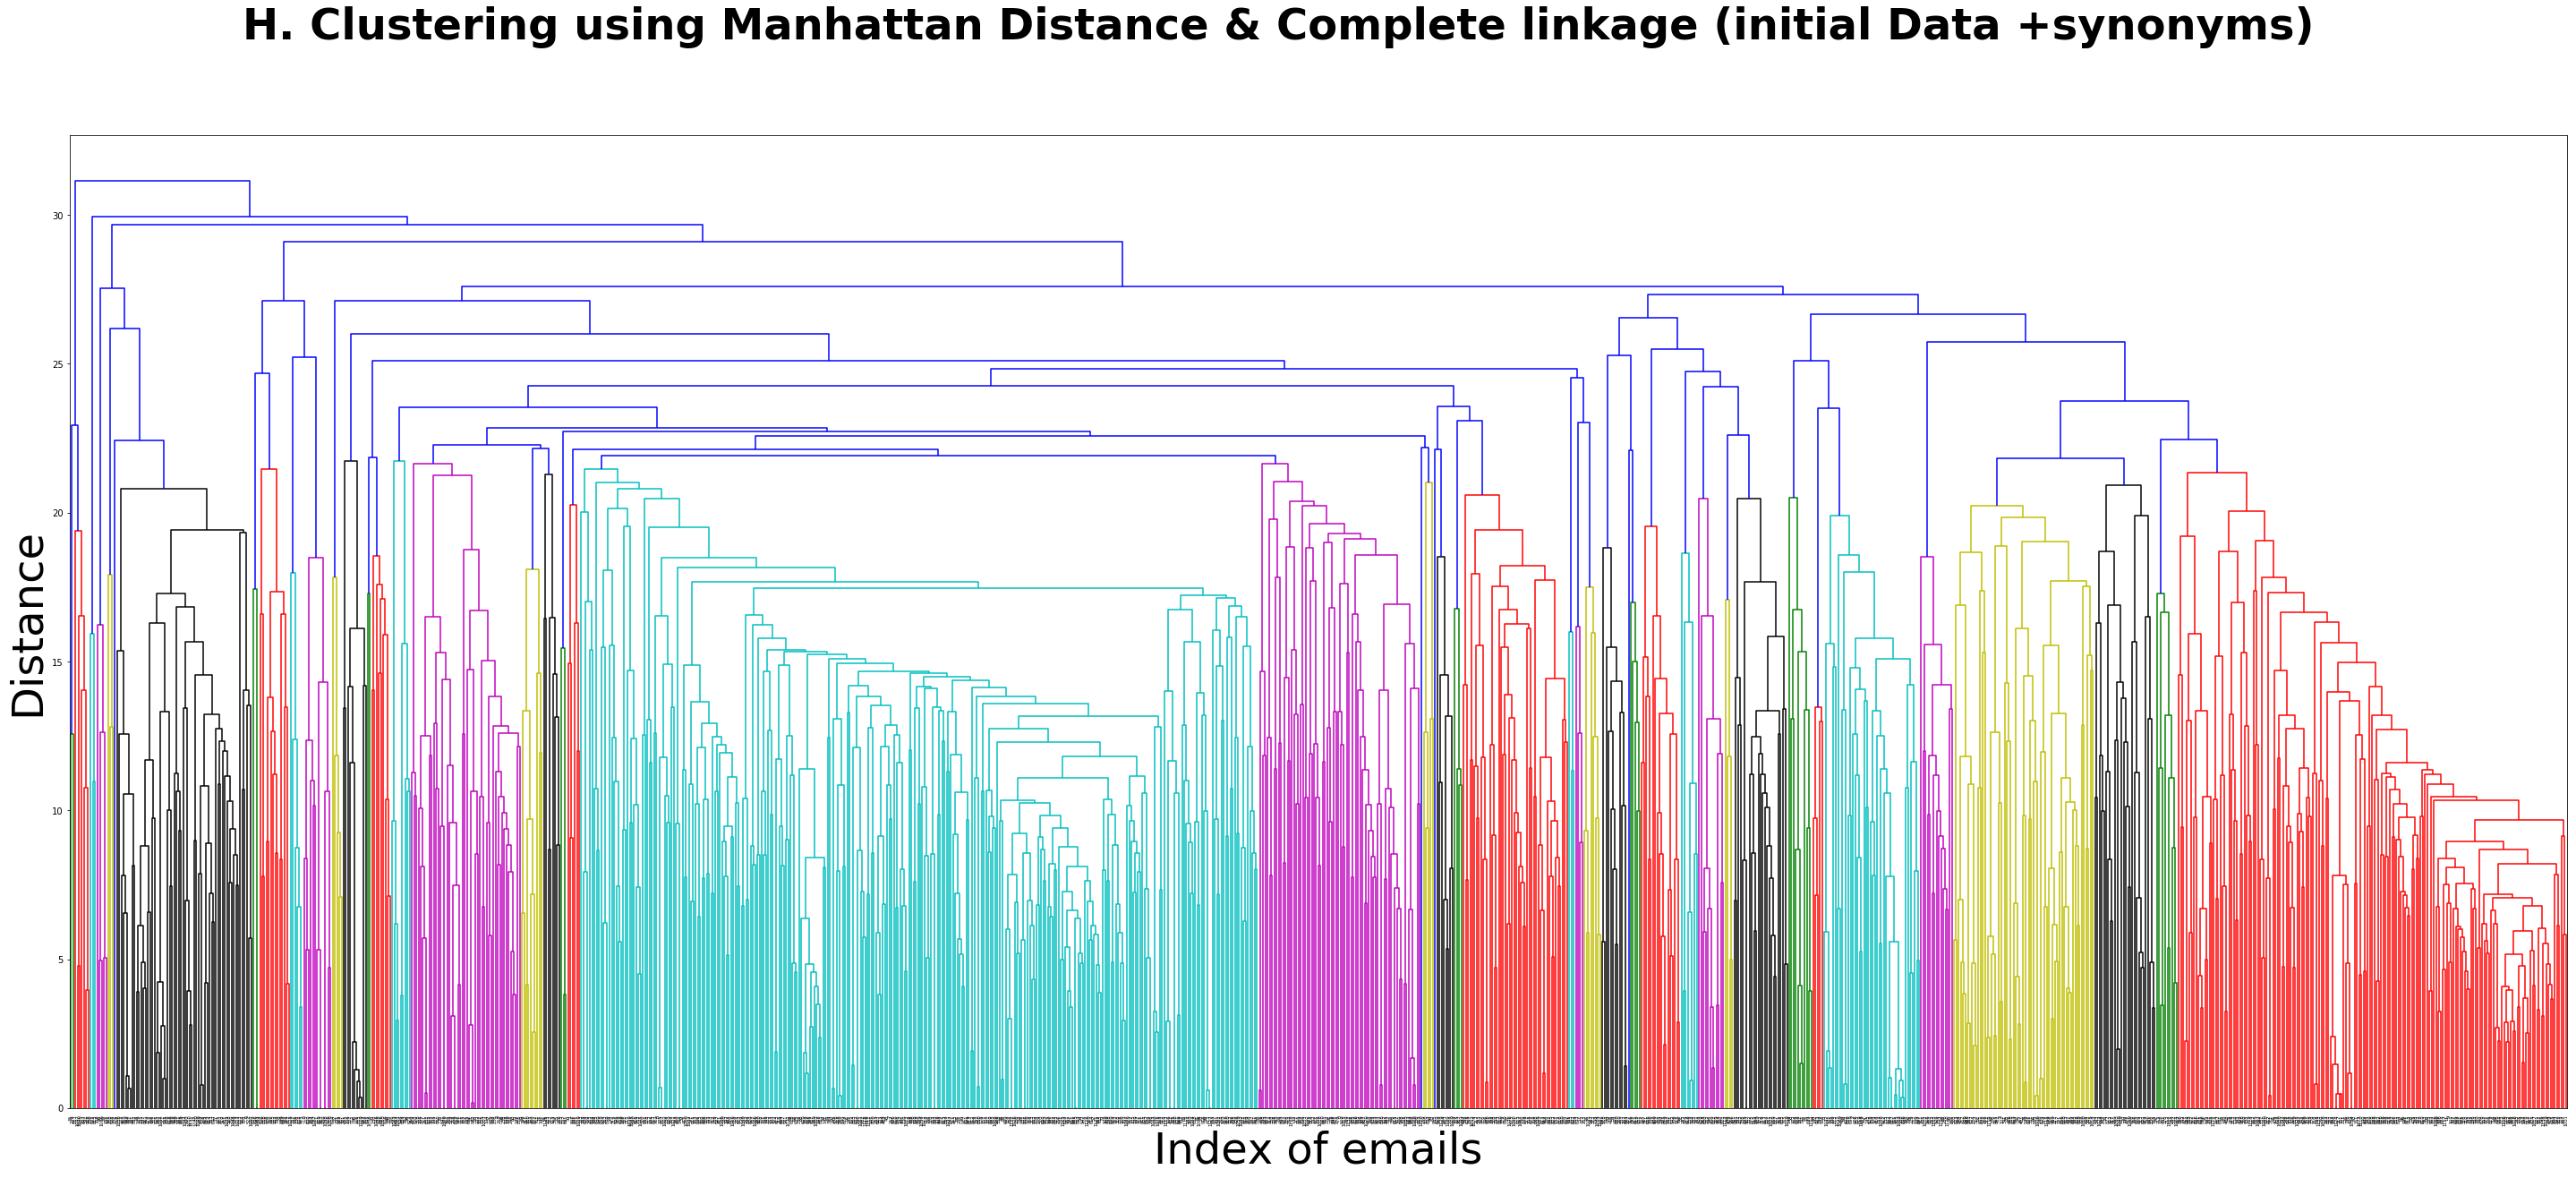

In [19]:
#setting the figure size
plt.subplots(figsize=(50, 20))

#Generating the plot
plt.xlabel('Index of emails', fontsize=48)
plt.ylabel('Distance', fontsize=48)
plt.suptitle('H. Clustering using Manhattan Distance & Complete linkage (initial Data +synonyms)', fontweight='bold', fontsize=48);
dend2 = sch.dendrogram(sch.linkage(X.todense(), method='complete',  metric='cityblock'))
plt.savefig("../results_dendrograms_kmeans_visualisation/HC2L2.png")

In [20]:
#extracting classes
get_cluster_classes(dend2)

g,"['35', '209', '696', '1081', '859', '595', '1076', '137', '641', '225', '967', '1091', '705', '954', '919', '971', '811', '798', '316', '58', '322', '742', '791', '938', '264', '694', '1101', '14', '82', '149', '126', '431', '713', '212', '1102', '532', '1064', '284', '170', '47']"
r,"['1047', '1090', '392', '998', '647', '605', '887', '576', '888', '204', '148', '510', '443', '799', '885', '790', '29', '869', '786', '917', '644', '70', '150', '288', '886', '40', '350', '606', '1065', '1046', '1', '845', '50', '871', '1039', '231', '349', '678', '687', '297', '1012', '217', '393', '1074', '346', '986', '770', '327', '328', '734', '333', '765', '779', '850', '27', '1078', '730', '978', '1057', '927', '271', '1040', '675', '990', '308', '672', '577', '973', '304', '648', '613', '912', '657', '1095', '685', '822', '442', '123', '616', '857', '330', '220', '642', '890', '912', '122', '487', '666', '706', '211', '485', '619', '244', '434', '502', '131', '542', '582', '115', '760', '309', '900', '143', '142', '933', '64', '794', '975', '390', '792', '312', '427', '984', '588', '972', '261', '866', '665', '836', '541', '51', '592', '247', '448', '114', '662', '1112', '340', '466', '26', '631', '124', '145', '213', '218', '73', '499', '966', '709', '1114', '735', '259', '865', '1067', '852', '731', '1050', '294', '412', '571', '880', '41', '404', '828', '1030', '797', '1062', '376', '889', '708', '945', '549', '343', '626', '492', '1025', '301', '569', '469', '110', '598', '179', '230', '1038', '1133', '362', '867', '936', '1124', '317', '701', '763', '237', '420', '1024', '796', '16', '221', '43', '351', '1073', '1110', '140', '643', '1073', '545', '870', '673', '882', '688', '686', '908', '233', '359', '293', '946', '471', '913', '922', '96', '87', '873', '851', '36', '405', '248', '787', '918', '369', '810', '553', '563', '749', '996', '1088', '684', '1117', '9', '101', '11', '710', '795', '326', '575', '521', '994', '656', '747', '296', '744', '395', '380', '740', '771', '776', '193', '676', '498', '934', '67', '716', '829', '528', '562', '1106', '449', '1018', '825', '175', '345', '775', '379', '584', '876', '914', '379', '624', '1017', '441', '921', '932', '396', '1134', '479', '645', '234', '1079', '597', '959', '444', '447', '1001', '773', '172', '93', '593', '638']"
c,"['533', '815', '156', '824', '925', '136', '186', '367', '1028', '653', '1061', '1083', '246', '546', '884', '94', '523', '782', '634', '759', '388', '265', '844', '363', '435', '590', '338', '583', '879', '974', '808', '374', '698', '596', '219', '477', '19', '228', '361', '1029', '1035', '703', '1045', '816', '690', '215', '310', '931', '117', '174', '128', '823', '962', '375', '807', '8', '334', '920', '1002', '504', '1021', '460', '544', '353', '415', '1000', '39', '347', '915', '1052', '536', '935', '103', '550', '826', '720', '793', '303', '712', '289', '947', '397', '403', '360', '1096', '470', '1056', '275', '923', '714', '411', '129', '1049', '732', '894', '767', '1066', '820', '355', '960', '151', '788', '729', '153', '163', '183', '302', '413', '454', '837', '216', '941', '1071', '66', '635', '628', '86', '784', '858', '600', '391', '457', '398', '861', '1003', '989', '68', '59', '141', '235', '84', '394', '97', '743', '468', '580', '926', '530', '674', '91', '242', '152', '863', '632', '840', '952', '1118', '1051', '319', '1111', '445', '800', '667', '723', '253', '164', '489', '7', '252', '48', '610', '646', '120', '1027', '446', '147', '496', '118', '188', '366', '839', '488', '939', '718', '736', '1011', '1094', '433', '493', '370', '108', '943', '222', '813', '864', '1031', '30', '977', '201', '65', '423', '511', '821', '979', '843', '617', '812', '292', '860', '429', '178', '257', '161', '849', '985', '1005', '704', '38', '88', '558', '436', '1122', '724', '630', '256', '733', '1026', '831', '846', '23', '313', '842', '758', '300', '278', '279', '640', '983', '320', '190', '281', '125', '483', '625', '531', '1105', '342', '611', '951', '654'

In [21]:
#From each classes, here I am extracting the corresponding index numbers of the emails falling in each class.
cluster_idxs_1 = defaultdict(list)
for c, pi in zip(dend2['color_list'], dend2['icoord']):
    for leg in pi[1:3]:
        i = (leg - 5.0) / 10.0
        if abs(i - int(i)) < 1e-5:
            cluster_idxs_1[c].append(int(i))

In [22]:
#Creating list of dataframes
list_of_values1=[]
for k, v in cluster_idxs_1.items():
    list_of_values1.append(v)
l_df1=[]
for l1 in list_of_values1:
    df_1 = pd.concat([pd.DataFrame(l1), data_subset], axis=1, join='inner')
    l_df1.append(df_1)

In [23]:
print("Output by Hierarchical clustering \n")
list_l_df1=[]
i=0
for l_d in l_df1:
   
    print("Total Emails in this cluster", i,"=",len(l_d.values.tolist()))
    i+=1
    list_l_df1.append(l_d.iloc[:,1:].values.tolist())

Output by Hierarchical clustering 

Total Emails in this cluster 0 = 40
Total Emails in this cluster 1 = 287
Total Emails in this cluster 2 = 381
Total Emails in this cluster 3 = 173
Total Emails in this cluster 4 = 100
Total Emails in this cluster 5 = 154
Total Emails in this cluster 6 = 4


### Preparing the Data for the application of LDA 

In [24]:
def data_prep2_for_lda(i):
    d_comp=[]
    for d in list_l_df1[i]:
        d_comp.append(''.join(str(d)))
    seg_cl=seg_clust(d_comp)
    lists_cl=[]
    for s_cl in seg_cl:
        lists_cl.append(' '.join(s_cl))
    return lists_cl

len_listofdf=len(list_l_df1)
doc_clean1=[]

for i in range(0,len(l_df1)):
    lists_cl1=data_prep2_for_lda(i)
    doc_clean1.append([clean(doc).split() for doc in list(set(lists_cl1))])
    
doc_cleean1=list(chain(*doc_clean1))

In [25]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary1 = corpora.Dictionary(doc_cleean1)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix1 = [dictionary1.doc2bow(doc) for doc in doc_cleean1]

#creating a dictionary from the final document
dictionary1 = gensim.corpora.Dictionary(doc_cleean1)

#Creating a bag of words
bow_corpus1 = [dictionary1.doc2bow(doc) for doc in doc_cleean1]

lda_model1 = gensim.models.LdaMulticore(bow_corpus1, num_topics=len(l_df1), id2word=dictionary1, passes=2, workers=2)

for idx, topic in lda_model1.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.022*"mortgage" + 0.013*"guaranteed" + 0.013*"penis" + 0.012*"quote" + 0.011*"harvest" + 0.010*"atiq" + 0.009*"medicine" + 0.009*"longer" + 0.009*"urpymoadnaog" + 0.009*"laquita"
Topic: 1 
Words: 0.019*"sale" + 0.014*"brand" + 0.013*"emailcom" + 0.011*"april" + 0.010*"vivek" + 0.010*"website" + 0.009*"barlow" + 0.009*"margene" + 0.009*"monday" + 0.009*"business"
Topic: 2 
Words: 0.024*"mail" + 0.018*"style" + 0.014*"insurance" + 0.013*"rate" + 0.012*"thomas" + 0.012*"phiri" + 0.011*"watch" + 0.010*"from" + 0.008*"leoni" + 0.008*"client"
Topic: 3 
Words: 0.015*"eliz" + 0.014*"diskeeper" + 0.012*"discount" + 0.012*"seko" + 0.011*"computer" + 0.011*"friend" + 0.010*"viagra" + 0.010*"loss" + 0.010*"beth" + 0.009*"astley"
Topic: 4 
Words: 0.039*"viagra" + 0.024*"pfizer" + 0.016*"best" + 0.016*"price" + 0.014*"store" + 0.012*"your" + 0.011*"want" + 0.011*"swreg" + 0.011*"time" + 0.011*"service"
Topic: 5 
Words: 0.033*"mail" + 0.023*"notification" + 0.015*"personal" + 0.013*

In [26]:
# Compute Perplexity : lowest perplexity is considered the best.
perplexity=lda_model1.log_perplexity(bow_corpus1)
print('\n Perplexity of the Spam Classification model: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda1 = CoherenceModel(model=lda_model1, texts=doc_cleean1, dictionary=dictionary1, coherence='c_v')
coherence_lda1 = coherence_model_lda1.get_coherence()
print('\n Coherence Score of the Spam Classification model: ', coherence_lda)


 Perplexity of the Spam Classification model:  -7.996657642170973

 Coherence Score of the Spam Classification model:  0.8188788161714328


In [27]:
pyLDAvis.enable_notebook()
id2word=dictionary1
vis = pyLDAvis.gensim.prepare(lda_model1, bow_corpus1, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
5      15.077469        1       1 -0.241181  0.059696
6      14.689326        1       2  0.122820  0.175994
4      14.386542        1       3  0.112506  0.042985
3      14.188257        1       4  0.069918  0.011557
2      13.977082        1       5 -0.120215  0.038993
1      13.961008        1       6  0.008822 -0.192371
0      13.720320        1       7  0.047330 -0.136854, topic_info=     Category       Freq          Term      Total  loglift  logprob
term                                                               
49    Default  41.000000        viagra  41.000000  30.0000  30.0000
8     Default  50.000000          mail  50.000000  29.0000  29.0000
168   Default  20.000000         great  20.000000  28.0000  28.0000
140   Default  22.000000         offer  22.000000  27.0000  27.0000
25    Default  22.000000  notification  22.000000  26.0000  26.0000
202   Default  22.000000        pfizer  22.000000  25.0000  25.0000
172   Default  17.000000      mortgage  17.000000  24.0000  24.0000
11    Default  19.000000          sale  19.000000  23.0000  23.0000
79    Default  15.000000         style  15.000000  22.0000  22.0000
51    Default  13.000000          best  13.000000  21.0000  21.0000
145   Default  13.000000         price  13.000000  20.0000  20.0000
48    Default  13.000000        system  13.000000  19.0000  19.0000
185   Default  13.000000      personal  13.000000  18.0000  18.0000
7     Default  11.000000     insurance  11.000000  17.0000  17.0000
413   Default  13.000000          eliz  13.000000  16.0000  16.0000
424   Default  11.000000      approval  11.000000  15.0000  15.0000
68    Default  12.000000        dealer  12.000000  14.0000  14.0000
426   Default  11.000000       suzanna  11.000000  13.0000  13.0000
12    Default  10.000000          rate  10.000000  12.0000  12.0000
117   Default  12.000000     diskeeper  12.000000  11.0000  11.0000
381   Default  10.000000          news  10.000000  10.0000  10.0000
205   Default  10.000000    guaranteed  10.000000   9.0000   9.0000
26    Default  10.000000      facebook  10.000000   8.0000   8.0000
548   Default  15.000000         brand  15.000000   7.0000   7.0000
14    Default  11.000000      emailcom  11.000000   6.0000   6.0000
396   Default  11.000000         penis  11.000000   5.0000   5.0000
991   Default  11.000000        thomas  11.000000   4.0000   4.0000
225   Default  10.000000      discount  10.000000   3.0000   3.0000
155   Default  10.000000        mining  10.000000   2.0000   2.0000
866   Default   9.000000      computer   9.000000   1.0000   1.0000
...       ...        ...           ...        ...      ...      ...
304    Topic7   4.806201       contain   5.496951   1.8520  -5.0366
679    Topic7   4.805772      endorsed   5.496893   1.8519  -5.0367
362    Topic7   6.599639        longer   7.579301   1.8479  -4.7195
23     Topic7   6.132004        buying   7.104253   1.8391  -4.7930
1068   Topic7   4.340709    intimating   5.030306   1.8388  -5.1385
1085   Topic7   4.340593    mastercard   5.030314   1.8388  -5.1385
467    Topic7   4.339932      kimberly   5.030253   1.8387  -5.1387
391    Topic7   4.339910         leoma   5.030250   1.8387  -5.1387
235    Topic7   5.113066          come   5.944432   1.8356  -4.9748
104    Topic7   5.113527        broker   5.950639   1.8347  -4.9747
188    Topic7   6.131834       require   7.143101   1.8336  -4.7931
93     Topic7   5.113928       dancing   5.959665   1.8332  -4.9746
16     Topic7   5.747833      delivery   6.841610   1.8121  -4.8577
219    Topic7   7.316946          atiq   8.751778   1.8072  -4.6164
431    Topic7   5.525129          love   6.620530   1.8054  -4.8972
387    Topic7   5.524704      hendrick   6.620504   1.8054  -4.8973
525    Topic7   8.416727       harvest  10.112659   1.8027  -4.4763
396    Topic7   9.290416         penis  11.254326   1.7945  -4.3776
499